In [5]:
import sys
import os
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import vis_utils
import misc_utils
import metric_utils

In [6]:
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from scipy.stats import norm, rankdata
import time
import lasagne
import gc

In [7]:
from generate_data import generate_nglf_from_model
from generate_data import generate_general_make_spd
from metric_utils import calculate_nll_score

# Try very large regularization when loss is paramterized this way: $\alpha* \mbox{main_obj} + (1 - \alpha)*\mbox{reg_obj} $.

In [8]:
try:
    import cudamat as cm

    GPU_SUPPORT = True
except:
    print("Install CUDA and cudamat (for python) to enable GPU speedups.")
    GPU_SUPPORT = False


def g(x, t=4):
    """A transformation that suppresses outliers for a standard normal."""
    xp = np.clip(x, -t, t)
    diff = np.tanh(x - xp)
    return xp + diff


def g_inv(x, t=4):
    """Inverse of g transform."""
    xp = np.clip(x, -t, t)
    diff = np.arctanh(np.clip(x - xp, -1 + 1e-10, 1 - 1e-10))
    return xp + diff


def mean_impute(x, v):
    """Missing values in the data, x, are indicated by v. Wherever this value appears in x, it is replaced by the
    mean value taken from the marginal distribution of that column."""
    if not np.isnan(v):
        x = np.where(x == v, np.nan, x)
    x_new = []
    n_obs = []
    for i, xi in enumerate(x.T):
        missing_locs = np.where(np.isnan(xi))[0]
        xi_nm = xi[np.isfinite(xi)]
        xi[missing_locs] = np.mean(xi_nm)
        x_new.append(xi)
        n_obs.append(len(xi_nm))
    return np.array(x_new).T, np.array(n_obs)


class TimeCorex(object):
    def __init__(self, nt, nv, n_hidden=10, max_iter=10000, tol=1e-5, anneal=True, missing_values=None,
                 discourage_overlap=True, gaussianize='standard', gpu=False, y_scale=1.0, update_iter=10,
                 pretrained_W=None, verbose=False, seed=None):

        self.nt = nt  # Number of timesteps
        self.nv = nv  # Number of variables
        self.m = n_hidden  # Number of latent factors to learn
        self.max_iter = max_iter  # Number of iterations to try
        self.tol = tol  # Threshold for convergence
        self.anneal = anneal
        self.eps = 0  # If anneal is True, it's adjusted during optimization to avoid local minima
        self.missing_values = missing_values

        self.discourage_overlap = discourage_overlap  # Whether or not to discourage overlapping latent factors
        self.gaussianize = gaussianize  # Preprocess data: 'standard' scales to zero mean and unit variance
        self.gpu = gpu  # Enable GPU support for some large matrix multiplications.
        if self.gpu:
            cm.cublas_init()

        self.y_scale = y_scale  # Can be arbitrary, but sets the scale of Y
        self.update_iter = update_iter  # Compute statistics every update_iter
        self.pretrained_W = pretrained_W  # the pretrained weights
        np.random.seed(seed)  # Set seed for deterministic results
        self.verbose = verbose
        if verbose:
            np.set_printoptions(precision=3, suppress=True, linewidth=160)
            print('Linear CorEx with {:d} latent factors'.format(n_hidden))

        self.history = [{} for t in range(self.nt)]  # Keep track of values for each iteration
        self.rng = RandomStreams(seed)

    def fit(self, x):
        x = [np.array(xt, dtype=np.float32) for xt in x]
        x = self.preprocess(x, fit=True)  # Fit a transform for each marginal
        self.x_std = x  # to have an access to standardalized x

        anneal_schedule = [0.]
        if self.anneal:
            anneal_schedule = [0.6 ** k for k in range(1, 7)] + [0]

        self._define_model()
        if self.pretrained_W is not None:
            for cur_w, pre_w in zip(self.ws, self.pretrained_W):
                cur_w.set_value(pre_w)

        for i_eps, eps in enumerate(anneal_schedule):
            start_time = time.time()

            self.eps = eps
            self.anneal_eps.set_value(np.float32(eps))
            self.moments = self._calculate_moments(x, self.ws, quick=True)
            self._update_u(x)

            for i_loop in range(self.max_iter):
                ret = self.train_step(*x)
                obj = ret[0]
                reg_obj = ret[2]

                if i_loop % self.update_iter == 0 and self.verbose:
                    self.moments = self._calculate_moments(x, self.ws, quick=True)
                    self._update_u(x)
                    print("tc = {}, obj = {}, reg = {}, eps = {}".format(np.sum(self.tc),
                                                                         obj, reg_obj, eps))

            print("Annealing iteration finished, time = {}".format(time.time() - start_time))

        self.moments = self._calculate_moments(x, self.ws, quick=False)  # Update moments with details
        return self

    def _update_u(self, x):
        self.us = [self.getus(w.get_value(), xt) for w, xt in zip(self.ws, x)]

    def update_records(self, moments, delta):
        """Print and store some statistics about each iteration."""
        gc.disable()  # There's a bug that slows when appending, fixed by temporarily disabling garbage collection
        for t in range(self.nt):
            self.history[t]["TC"] = self.history[t].get("TC", []) + [moments[t]["TC"]]
        if self.verbose > 1:
            tc_sum = sum([m["TC"] for m in moments])
            add_sum = sum([m.get("additivity", 0) for m in moments])
            print("TC={:.3f}\tadd={:.3f}\tdelta={:.6f}".format(tc_sum, add_sum, delta))
        if self.verbose:
            for t in range(self.nt):
                self.history[t]["additivity"] = self.history[t].get("additivity", []) + [
                    moments[t].get("additivity", 0)]
                self.history[t]["TCs"] = self.history[t].get("TCs", []) + [moments[t].get("TCs", np.zeros(self.m))]
        gc.enable()

    @property
    def tc(self):
        """This actually returns the lower bound on TC that is optimized. The lower bound assumes a constraint that
         would be satisfied by a non-overlapping model.
         Check "moments" for two other estimates of TC that may be useful."""
        return [m["TC"] for m in self.moments]

    @property
    def tcs(self):
        """TCs for each individual latent factor. They DO NOT sum to TC in this case, because of overlaps."""
        return [m["TCs"] for m in self.moments]

    @property
    def mis(self):
        return [-0.5 * np.log1p(-m["rho"] ** 2) for m in self.moments]

    def clusters(self):
        return np.argmax(np.abs(self.us), axis=0)  # TODO: understand this

    def _sig(self, x, u):
        """Multiple the matrix u by the covariance matrix of x. We are interested in situations where
        n_variables >> n_samples, so we do this without explicitly constructing the covariance matrix."""
        n_samples = x.shape[0]
        if self.gpu:
            y = cm.empty((n_samples, self.m))
            uc = cm.CUDAMatrix(u)
            cm.dot(x, uc.T, target=y)
            del uc
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del y
            del tmp
        else:
            y = x.dot(u.T)
            tmp_dot = x.T.dot(y)
        prod = (1 - self.eps ** 2) * tmp_dot.T / n_samples + self.eps ** 2 * u  # nv by m,  <X_i Y_j> / std Y_j
        return prod

    def getus(self, w, x):
        # U_{ji} = \frac{W_{ji}}{\sqrt{E[Z_j^2]}}
        """
        U = np.zeros(W.shape)
        for j in range(W.shape[0]):
            U[j, :] = W[j, :] / np.sqrt(self.z2_fromW(j, W, x))
        return U
        """
        tmp_dot = np.dot(self._sig(x, w), w.T)
        z2 = self.y_scale ** 2 + np.einsum("ii->i", tmp_dot)
        return w / np.sqrt(z2).reshape((-1, 1))

    def _calculate_moments(self, x, ws, quick=False):
        us = [self.getus(w.get_value(), xt) for w, xt in zip(ws, x)]
        ret = [None] * self.nt
        for t in range(self.nt):
            if self.discourage_overlap:
                ret[t] = self._calculate_moments_ns(x[t], us[t], quick=quick)
            else:
                ret[t] = self._calculate_moments_syn(x[t], us[t], quick=quick)
        return ret

    def _calculate_moments_ns(self, x, ws, quick=False):
        """Calculate moments based on the weights and samples. We also calculate and save MI, TC, additivity, and
        the value of the objective. Note it is assumed that <X_i^2> = 1! """
        m = {}  # Dictionary of moments
        n_samples = x.shape[0]
        if self.gpu:
            y = cm.empty((n_samples, self.m))
            wc = cm.CUDAMatrix(ws)
            cm.dot(x, wc.T, target=y)  # + noise, but it is included analytically
            del wc
            tmp_sum = np.einsum('lj,lj->j', y.asarray(), y.asarray())  # TODO: Should be able to do on gpu...
        else:
            y = x.dot(ws.T)
            tmp_sum = np.einsum('lj,lj->j', y, y)
        m["uj"] = (1 - self.eps ** 2) * tmp_sum / n_samples + self.eps ** 2 * np.sum(ws ** 2, axis=1)

        if self.gpu:
            tmp = cm.empty((self.nv, self.m))
            cm.dot(x.T, y, target=tmp)
            tmp_dot = tmp.asarray()
            del tmp
            del y
        else:
            tmp_dot = x.T.dot(y)
        m["rho"] = (1 - self.eps ** 2) * tmp_dot.T / n_samples + self.eps ** 2 * ws  # m by nv
        m["ry"] = ws.dot(m["rho"].T)  # normalized covariance of Y
        m["Y_j^2"] = self.y_scale ** 2 / (1. - m["uj"])
        np.fill_diagonal(m["ry"], 1)
        m["invrho"] = 1. / (1. - m["rho"] ** 2)
        m["rhoinvrho"] = m["rho"] * m["invrho"]
        m["Qij"] = np.dot(m['ry'], m["rhoinvrho"])
        m["Qi"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        # m["Qi-Si^2"] = np.einsum('ki,ki->i', m["rhoinvrho"], m["Qij"])
        m["Si"] = np.sum(m["rho"] * m["rhoinvrho"], axis=0)

        # This is the objective, a lower bound for TC
        m["TC"] = np.sum(np.log(1 + m["Si"])) \
                  - 0.5 * np.sum(np.log(1 - m["Si"] ** 2 + m["Qi"])) \
                  + 0.5 * np.sum(np.log(1 - m["uj"]))

        if not quick:
            m["MI"] = - 0.5 * np.log1p(-m["rho"] ** 2)
            m["X_i Y_j"] = m["rho"].T * np.sqrt(m["Y_j^2"])
            m["X_i Z_j"] = np.linalg.solve(m["ry"], m["rho"]).T
            m["X_i^2 | Y"] = (1. - np.einsum('ij,ji->i', m["X_i Z_j"], m["rho"])).clip(1e-6)
            m['I(Y_j ; X)'] = 0.5 * np.log(m["Y_j^2"]) - 0.5 * np.log(self.y_scale ** 2)
            m['I(X_i ; Y)'] = - 0.5 * np.log(m["X_i^2 | Y"])
            m["TCs"] = m["MI"].sum(axis=1) - m['I(Y_j ; X)']
            m["TC_no_overlap"] = m["MI"].max(axis=0).sum() - m[
                'I(Y_j ; X)'].sum()  # A direct calculation of TC where each variable is in exactly one group.
            m["TC_direct"] = m['I(X_i ; Y)'].sum() - m[
                'I(Y_j ; X)']  # A direct calculation of TC. Should be upper bound for "TC", "TC_no_overlap"
            m["additivity"] = (m["MI"].sum(axis=0) - m['I(X_i ; Y)']).sum()
        return m

    def _calculate_moments_syn(self, x, ws, quick=False):
        return None

    def transform(self, x, details=False):
        """Transform an array of inputs, x, into an array of k latent factors, Y.
            Optionally, you can get the remainder information and/or stop at a specified level."""
        x = self.preprocess(x)
        ret = [a.dot(w.get_value().T) for (a, w) in zip(x, self.ws)]
        if details:
            moments = self._calculate_moments(x, self.us)
            return ret, moments
        return ret

    def preprocess(self, X, fit=False):
        """Transform each marginal to be as close to a standard Gaussian as possible.
        'standard' (default) just subtracts the mean and scales by the std.
        'empirical' does an empirical gaussianization (but this cannot be inverted).
        'outliers' tries to squeeze in the outliers
        Any other choice will skip the transformation."""
        ret = [None] * len(X)
        if fit:
            self.theta = []
        for t in range(len(X)):
            x = X[t]
            if self.missing_values is not None:
                x, n_obs = mean_impute(x, self.missing_values)  # Creates a copy
            else:
                n_obs = len(x)
            if self.gaussianize == 'none':
                pass
            elif self.gaussianize == 'standard':
                if fit:
                    mean = np.mean(x, axis=0)
                    # std = np.std(x, axis=0, ddof=0).clip(1e-10)
                    std = np.sqrt(np.sum((x - mean) ** 2, axis=0) / n_obs).clip(1e-10)
                    self.theta.append((mean, std))
                x = ((x - self.theta[t][0]) / self.theta[t][1])
                if np.max(np.abs(x)) > 6 and self.verbose:
                    print("Warning: outliers more than 6 stds away from mean. Consider using gaussianize='outliers'")
            elif self.gaussianize == 'outliers':
                if fit:
                    mean = np.mean(x, axis=0)
                    std = np.std(x, axis=0, ddof=0).clip(1e-10)
                    self.theta.append((mean, std))
                x = g((x - self.theta[t][0]) / self.theta[t][1])  # g truncates long tails
            elif self.gaussianize == 'empirical':
                print("Warning: correct inversion/transform of empirical gauss transform not implemented.")
                x = np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
            if self.gpu and fit:  # Don't return GPU matrices when only transforming
                x = cm.CUDAMatrix(x)
            ret[t] = x
        return ret

    def invert(self, x):
        # TODO: consider timesteps
        """Invert the preprocessing step to get x's in the original space."""
        if self.gaussianize == 'standard':
            return self.theta[1] * x + self.theta[0]
        elif self.gaussianize == 'outliers':
            return self.theta[1] * g_inv(x) + self.theta[0]
        else:
            return x

    def predict(self, y):
        # NOTE: not sure what does this function do
        ret = [None] * self.nt
        for t in range(self.nt):
            ret[t] = self.invert(np.dot(self.moments[t]["X_i Z_j"], y[t].T).T)
        return ret

    def get_covariance(self):
        # This uses E(Xi|Y) formula for non-synergistic relationships
        m = self.moments
        ret = [None] * self.nt
        for t in range(self.nt):
            if self.discourage_overlap:
                z = m[t]['rhoinvrho'] / (1 + m[t]['Si'])
                cov = np.dot(z.T, z)
                cov /= (1. - self.eps ** 2)
                np.fill_diagonal(cov, 1)
                ret[t] = self.theta[t][1][:, np.newaxis] * self.theta[t][1] * cov
            else:
                cov = np.einsum('ij,kj->ik', m[t]["X_i Z_j"], mp[t]["X_i Y_j"])
                np.fill_diagonal(cov, 1)
                ret[t] = self.theta[t][1][:, np.newaxis] * self.theta[t][1] * cov
        return ret


class TimeCorexW(TimeCorex):
    def __init__(self, l1=0.0, l2=0.0, **kwargs):
        super(TimeCorexW, self).__init__(**kwargs)
        self.l1 = l1
        self.l2 = l2

    def _define_model(self):

        self.x_wno = [None] * self.nt
        self.x = [None] * self.nt
        self.ws = [None] * self.nt
        self.z_mean = [None] * self.nt
        self.z = [None] * self.nt

        self.anneal_eps = theano.shared(np.float32(0))

        for t in range(self.nt):
            self.x_wno[t] = T.matrix('X')
            ns = self.x_wno[t].shape[0]
            anneal_noise = self.rng.normal(size=(ns, self.nv))
            self.x[t] = np.sqrt(1 - self.anneal_eps ** 2) * self.x_wno[t] + self.anneal_eps * anneal_noise
            z_noise = self.rng.normal(avg=0.0, std=self.y_scale, size=(ns, self.m))
            self.ws[t] = theano.shared(1.0 / np.sqrt(self.nv) * np.random.randn(self.m, self.nv), name='W{}'.format(t))
            self.z_mean[t] = T.dot(self.x[t], self.ws[t].T)
            self.z[t] = self.z_mean[t] + z_noise

        EPS = 1e-5
        self.objs = [None] * self.nt
        self.sigma = [None] * self.nt

        for t in range(self.nt):
            z2 = (self.z[t] ** 2).mean(axis=0)  # (m,)
            ns = self.x_wno[t].shape[0]
            R = T.dot(self.z[t].T, self.x[t]) / ns  # m, nv
            R = R / T.sqrt(z2).reshape((self.m, 1))  # as <x^2_i> == 1 we don't divide by it
            ri = ((R ** 2) / T.clip(1 - R ** 2, EPS, 1 - EPS)).sum(axis=0)  # (nv,)

            # v_xi | z conditional mean
            outer_term = (1 / (1 + ri)).reshape((1, self.nv))
            inner_term_1 = (R / T.clip(1 - R ** 2, EPS, 1) / T.sqrt(z2).reshape((self.m, 1))).reshape(
                (1, self.m, self.nv))
            inner_term_2 = self.z[t].reshape((ns, self.m, 1))
            cond_mean = outer_term * ((inner_term_1 * inner_term_2).sum(axis=1))  # (ns, nv)

            inner_mat = 1.0 / (1 + ri).reshape((1, self.nv)) * R / T.clip(1 - R ** 2, EPS, 1)
            self.sigma[t] = T.dot(inner_mat.T, inner_mat)
            self.sigma[t] = self.sigma[t] * (1 - T.eye(self.nv)) + T.eye(self.nv)

            # objective
            obj_part_1 = 0.5 * T.log(T.clip(((self.x[t] - cond_mean) ** 2).mean(axis=0), EPS, np.inf)).sum(axis=0)
            obj_part_2 = 0.5 * T.log(z2).sum(axis=0)
            self.objs[t] = obj_part_1 + obj_part_2

        self.main_obj = T.sum(self.objs)

        # regularization
        self.reg_obj = T.constant(0)

        if self.l1 > 0:
            l1_reg = T.sum([T.abs_(self.ws[t + 1] - self.ws[t]).sum() for t in range(self.nt - 1)])
            self.reg_obj = self.reg_obj + self.l1 * l1_reg

        if self.l2 > 0:
            l2_reg = T.sum([T.square(self.ws[t + 1] - self.ws[t]).sum() for t in range(self.nt - 1)])
            self.reg_obj = self.reg_obj + self.l2 * l2_reg

        self.total_obj = self.main_obj + self.reg_obj

        # optimizer
        updates = lasagne.updates.adam(self.total_obj, self.ws)

        # functions
        self.train_step = theano.function(inputs=self.x_wno,
                                          outputs=[self.total_obj, self.main_obj, self.reg_obj] + self.objs,
                                          updates=updates)

        self.get_norm_covariance = theano.function(inputs=self.x_wno,
                                                   outputs=self.sigma)

### Load some data

In [9]:
m = 8
bs = 16
nv = m * bs
train_cnt = 8
test_cnt = 100
nt = 5
(data, ground_truth) = generate_nglf_from_model(nv=nv, m=m, nt=nt, ns=train_cnt + test_cnt, snr=5.0)

train_data = [X[:train_cnt] for X in data]
test_data = [X[train_cnt:] for X in data]

Fixed SNR: 5.0


In [10]:
corex = TimeCorexW(nt=nt,
                   nv=nv,
                   n_hidden=m,
                   max_iter=500,
                   verbose=False,
                   anneal=True,
                   l1=1000000)

In [11]:
corex.fit(train_data)

Annealing iteration finished, time = 2.63227391243
Annealing iteration finished, time = 2.60867881775
Annealing iteration finished, time = 2.60902094841
Annealing iteration finished, time = 2.60519385338
Annealing iteration finished, time = 1.84339499474
Annealing iteration finished, time = 1.94675993919
Annealing iteration finished, time = 1.68544888496


In [12]:
W = [x.get_value() for x in corex.ws]

In [13]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.0332891165883


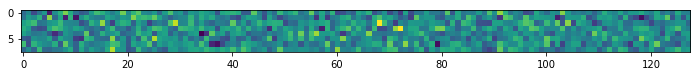

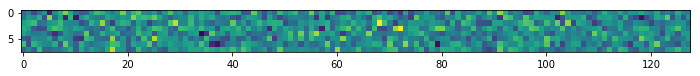

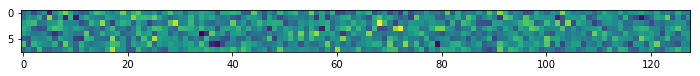

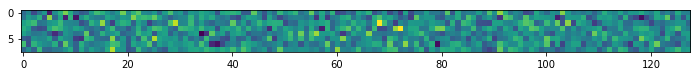

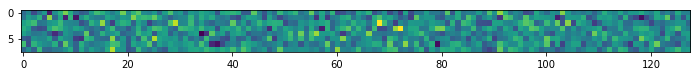

In [14]:
for w in W:
    plt.figure(figsize=(12, 6))
    plt.imshow(w)

In [15]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.000197049536134


## Time Corex on W with different loss parametrization

In [16]:
class TimeCorexWDifferent(TimeCorex):
    def __init__(self, alpha=0.0, **kwargs):
        super(TimeCorexWDifferent, self).__init__(**kwargs)
        self.alpha = alpha

    def _define_model(self):

        self.x_wno = [None] * self.nt
        self.x = [None] * self.nt
        self.ws = [None] * self.nt
        self.z_mean = [None] * self.nt
        self.z = [None] * self.nt

        self.anneal_eps = theano.shared(np.float32(0))

        for t in range(self.nt):
            self.x_wno[t] = T.matrix('X')
            ns = self.x_wno[t].shape[0]
            anneal_noise = self.rng.normal(size=(ns, self.nv))
            self.x[t] = np.sqrt(1 - self.anneal_eps ** 2) * self.x_wno[t] + self.anneal_eps * anneal_noise
            z_noise = self.rng.normal(avg=0.0, std=self.y_scale, size=(ns, self.m))
            self.ws[t] = theano.shared(1.0 / np.sqrt(self.nv) * np.random.randn(self.m, self.nv), name='W{}'.format(t))
            self.z_mean[t] = T.dot(self.x[t], self.ws[t].T)
            self.z[t] = self.z_mean[t] + z_noise

        EPS = 1e-5
        self.objs = [None] * self.nt
        self.sigma = [None] * self.nt

        for t in range(self.nt):
            z2 = (self.z[t] ** 2).mean(axis=0)  # (m,)
            ns = self.x_wno[t].shape[0]
            R = T.dot(self.z[t].T, self.x[t]) / ns  # m, nv
            R = R / T.sqrt(z2).reshape((self.m, 1))  # as <x^2_i> == 1 we don't divide by it
            ri = ((R ** 2) / T.clip(1 - R ** 2, EPS, 1 - EPS)).sum(axis=0)  # (nv,)

            # v_xi | z conditional mean
            outer_term = (1 / (1 + ri)).reshape((1, self.nv))
            inner_term_1 = (R / T.clip(1 - R ** 2, EPS, 1) / T.sqrt(z2).reshape((self.m, 1))).reshape(
                (1, self.m, self.nv))
            inner_term_2 = self.z[t].reshape((ns, self.m, 1))
            cond_mean = outer_term * ((inner_term_1 * inner_term_2).sum(axis=1))  # (ns, nv)

            inner_mat = 1.0 / (1 + ri).reshape((1, self.nv)) * R / T.clip(1 - R ** 2, EPS, 1)
            self.sigma[t] = T.dot(inner_mat.T, inner_mat)
            self.sigma[t] = self.sigma[t] * (1 - T.eye(self.nv)) + T.eye(self.nv)

            # objective
            obj_part_1 = 0.5 * T.log(T.clip(((self.x[t] - cond_mean) ** 2).mean(axis=0), EPS, np.inf)).sum(axis=0)
            obj_part_2 = 0.5 * T.log(z2).sum(axis=0)
            self.objs[t] = obj_part_1 + obj_part_2

        self.main_obj = T.sum(self.objs)
        self.reg_obj = T.mean([T.abs_(self.ws[t + 1] - self.ws[t]).mean() for t in range(self.nt - 1)])
        #self.reg_obj = T.sum([T.square(self.ws[t + 1] - self.ws[t]).sum() for t in range(self.nt - 1)])
        
        self.total_obj = self.alpha * self.main_obj + (1-self.alpha) * self.reg_obj

        # optimizer
        updates = lasagne.updates.adam(self.total_obj, self.ws)

        # functions
        self.train_step = theano.function(inputs=self.x_wno,
                                          outputs=[self.total_obj, self.main_obj, self.reg_obj] + self.objs,
                                          updates=updates)

        self.get_norm_covariance = theano.function(inputs=self.x_wno,
                                                   outputs=self.sigma)

In [17]:
corex = TimeCorexWDifferent(nt=nt,
                           nv=nv,
                           n_hidden=m,
                           max_iter=500,
                           verbose=True,
                           anneal=True,
                           alpha=0)

Linear CorEx with 8 latent factors


In [18]:
corex.fit(train_data)

tc = 70.8543764763, obj = 0.101857903612, reg = 0.101857903612, eps = 0.6
tc = 67.2641620708, obj = 0.0876238555959, reg = 0.0876238555959, eps = 0.6
tc = 63.4899576544, obj = 0.0748719147337, reg = 0.0748719147337, eps = 0.6
tc = 59.8587988345, obj = 0.0635715370655, reg = 0.0635715370655, eps = 0.6
tc = 56.1464285936, obj = 0.0536726224624, reg = 0.0536726224624, eps = 0.6
tc = 52.3732805758, obj = 0.0450373738629, reg = 0.0450373738629, eps = 0.6
tc = 48.7991168572, obj = 0.0374983165011, reg = 0.0374983165011, eps = 0.6
tc = 45.4388815907, obj = 0.0311711636607, reg = 0.0311711636607, eps = 0.6
tc = 42.4381430036, obj = 0.0257820395849, reg = 0.0257820395849, eps = 0.6
tc = 39.9430548478, obj = 0.0213082986501, reg = 0.0213082986501, eps = 0.6
tc = 37.6471368455, obj = 0.01761115734, reg = 0.01761115734, eps = 0.6
tc = 35.8233977408, obj = 0.0144763384042, reg = 0.0144763384042, eps = 0.6
tc = 34.4950260114, obj = 0.0118303206468, reg = 0.0118303206468, eps = 0.6
tc = 33.5762301976

tc = 63.2231559123, obj = 0.00020190678437, reg = 0.00020190678437, eps = 0.216
tc = 63.2259042577, obj = 0.000203848138131, reg = 0.000203848138131, eps = 0.216
tc = 63.1901134475, obj = 0.000204733444555, reg = 0.000204733444555, eps = 0.216
tc = 63.2507976982, obj = 0.000204113664956, reg = 0.000204113664956, eps = 0.216
tc = 63.2350204643, obj = 0.000197759523467, reg = 0.000197759523467, eps = 0.216
tc = 63.267796497, obj = 0.000202100781269, reg = 0.000202100781269, eps = 0.216
tc = 63.2307111192, obj = 0.000204678650229, reg = 0.000204678650229, eps = 0.216
tc = 63.1650271343, obj = 0.000200684447374, reg = 0.000200684447374, eps = 0.216
tc = 63.2476130368, obj = 0.000198861831201, reg = 0.000198861831201, eps = 0.216
tc = 63.1905958571, obj = 0.000199618466551, reg = 0.000199618466551, eps = 0.216
tc = 63.2367016045, obj = 0.000205599559764, reg = 0.000205599559764, eps = 0.216
tc = 63.2194646956, obj = 0.000200848514821, reg = 0.000200848514821, eps = 0.216
tc = 63.2442262248,

tc = 68.9270454746, obj = 0.000197397229817, reg = 0.000197397229817, eps = 0.07776
tc = 68.9287552162, obj = 0.000198500336977, reg = 0.000198500336977, eps = 0.07776
tc = 68.9479744716, obj = 0.000204531527133, reg = 0.000204531527133, eps = 0.07776
tc = 68.9356113241, obj = 0.000201921685879, reg = 0.000201921685879, eps = 0.07776
tc = 68.9738614411, obj = 0.00019883197962, reg = 0.00019883197962, eps = 0.07776
tc = 68.9789598845, obj = 0.000202397881769, reg = 0.000202397881769, eps = 0.07776
tc = 69.0063737632, obj = 0.000199584961411, reg = 0.000199584961411, eps = 0.07776
tc = 68.9541530216, obj = 0.000203846551546, reg = 0.000203846551546, eps = 0.07776
tc = 68.9666696862, obj = 0.000201387480553, reg = 0.000201387480553, eps = 0.07776
tc = 68.8921629097, obj = 0.0002038935672, reg = 0.0002038935672, eps = 0.07776
tc = 68.9885689311, obj = 0.000196385197858, reg = 0.000196385197858, eps = 0.07776
tc = 68.9477008077, obj = 0.000197962566117, reg = 0.000197962566117, eps = 0.0777

tc = 69.8538868766, obj = 0.000199881157708, reg = 0.000199881157708, eps = 0
tc = 69.8264245968, obj = 0.000201198767028, reg = 0.000201198767028, eps = 0
tc = 69.8318525506, obj = 0.000197439547696, reg = 0.000197439547696, eps = 0
tc = 69.8380753946, obj = 0.000196348611706, reg = 0.000196348611706, eps = 0
tc = 69.7628084373, obj = 0.00019715562664, reg = 0.00019715562664, eps = 0
tc = 69.8300312933, obj = 0.000193352617567, reg = 0.000193352617567, eps = 0
tc = 69.7745230895, obj = 0.000203884556076, reg = 0.000203884556076, eps = 0
tc = 69.865603195, obj = 0.000200388714855, reg = 0.000200388714855, eps = 0
tc = 69.7967002682, obj = 0.000197410571748, reg = 0.000197410571748, eps = 0
tc = 69.854361552, obj = 0.000197305148891, reg = 0.000197305148891, eps = 0
tc = 69.8778097631, obj = 0.000194517199374, reg = 0.000194517199374, eps = 0
tc = 69.8518838803, obj = 0.000196245513926, reg = 0.000196245513926, eps = 0
tc = 69.8927774172, obj = 0.000198681624225, reg = 0.000198681624225

In [19]:
W = [x.get_value() for x in corex.ws]

In [20]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.0333327333225


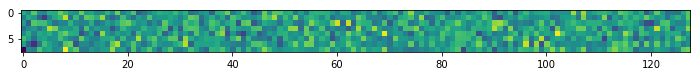

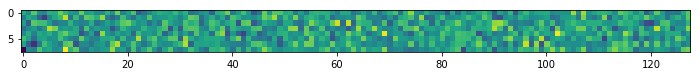

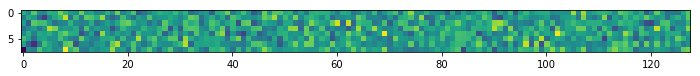

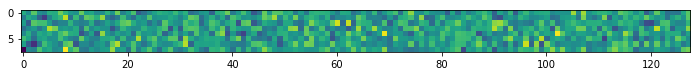

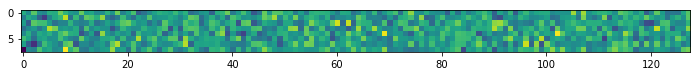

In [21]:
for w in W:
    plt.figure(figsize=(12, 6))
    plt.imshow(w)

In [22]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.000196128650966


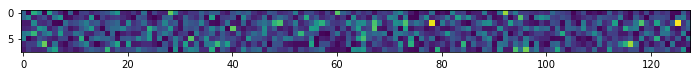

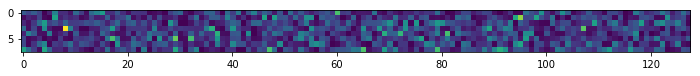

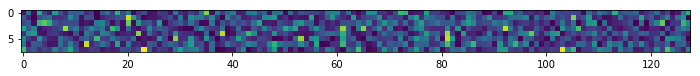

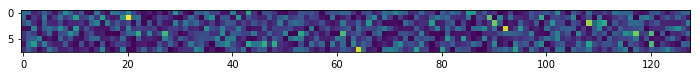

In [23]:
for t in range(nt - 1):
    plt.figure(figsize=(12, 6))
    plt.imshow(np.abs(W[t]-W[t+1]))

In [24]:
covs = corex.get_covariance()

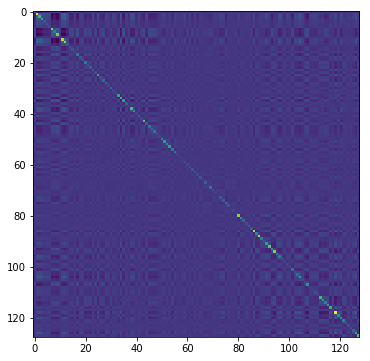

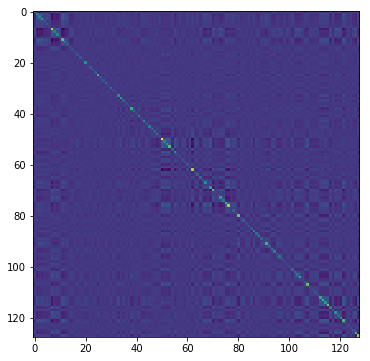

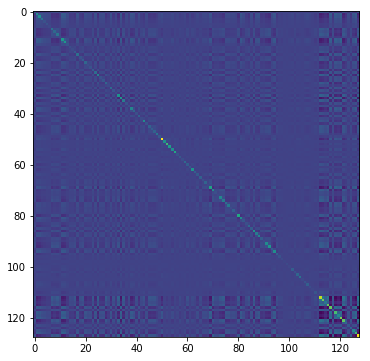

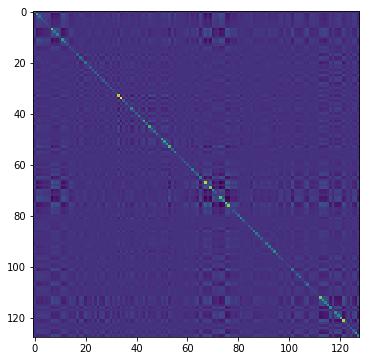

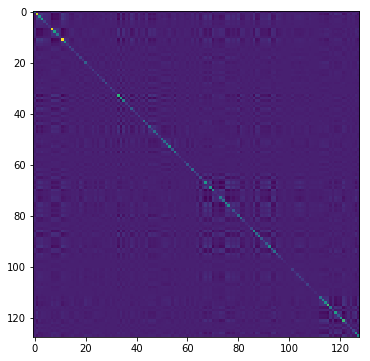

In [25]:
for cov in covs:
    plt.figure(figsize=(6,6))
    plt.imshow(cov)